In this notebook, using financial data from FMP, we experiment using Sigma Anomaly Detection on Financial Data

Function to retrieve stock data from FMP

In [ ]:
import requests
import pandas as pd

def get_stock_data(symbol, start_date, end_date, api_key):
    """
    Fetches historical stock data from Financial Modeling Prep (FMP) API 
    for a given stock symbol within a specified date range.

    :param symbol: Stock symbol (e.g., 'AAPL')
    :param start_date: Start date (YYYY-MM-DD)
    :param end_date: End date (YYYY-MM-DD)
    :param api_key: Your FMP API key
    :return: Pandas Series of closing prices with date index
    """
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?apikey={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        historical_prices = data.get("historical", [])

        # Convert to DataFrame
        df = pd.DataFrame(historical_prices)

        # Keep only date and closing price
        df = df[["date", "close"]]
        df["date"] = pd.to_datetime(df["date"])
        df.set_index("date", inplace=True)

        # Sort index in ascending order (Fix for KeyError)
        df = df.sort_index()

        # Ensure requested date range is available in data
        available_dates = df.index
        if pd.to_datetime(start_date) not in available_dates or pd.to_datetime(end_date) not in available_dates:
            print("Warning: Requested date range not fully available in the dataset.")
        
        # Filter by the given date range
        df = df.loc[start_date:end_date]

        return df["close"]

    else:
        print("Error:", response.status_code, response.text)
        return None




Put your API key from FMP and feel free to modify the **symbol**, **start_date** and **end_date** for a different timeseries.

You can get the API key from [Here](https://site.financialmodelingprep.com)

In [ ]:
# Define API Key
API_KEY = ""

# Define stock symbol and date range
symbol = "NVDA"  # Nvidia stock
start_date = "2024-12-02"
end_date = "2025-01-17"

# Fetch stock data
timeseries = get_stock_data(symbol, start_date, end_date, API_KEY)

# Print result
print(timeseries)


date
2024-12-02    138.63
2024-12-03    140.26
2024-12-04    145.14
2024-12-05    145.06
2024-12-06    142.44
2024-12-09    138.81
2024-12-10    135.07
2024-12-11    139.31
2024-12-12    137.34
2024-12-13    134.25
2024-12-16    132.00
2024-12-17    130.39
2024-12-18    128.91
2024-12-19    130.68
2024-12-20    134.70
2024-12-23    139.67
2024-12-24    140.22
2024-12-26    139.93
2024-12-27    137.01
2024-12-30    137.49
2024-12-31    134.29
2025-01-02    138.31
2025-01-03    144.47
2025-01-06    149.43
2025-01-07    140.14
2025-01-08    140.11
2025-01-10    135.91
2025-01-13    133.23
2025-01-14    131.76
2025-01-15    136.24
2025-01-16    133.57
2025-01-17    137.71
Name: close, dtype: float64


Now that we have our data, we can plot it

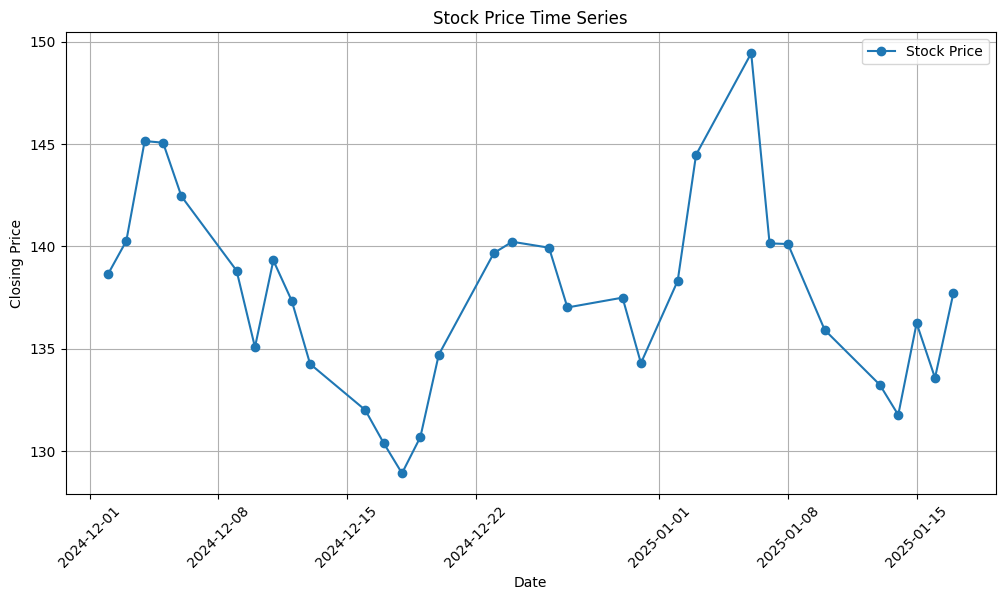

In [10]:
import matplotlib.pyplot as plt

def plot_time_series(timeseries, title="Stock Price Time Series"):
    """
    Plots the time series data for stock prices.

    :param timeseries: Pandas Series with datetime index
    :param title: Title of the plot
    """
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries.index, timeseries.values, marker='o', linestyle='-', label="Stock Price")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming `timeseries` is already fetched using the modified function
plot_time_series(timeseries)


Now we can apply Sigma Anomaly Detection on our data

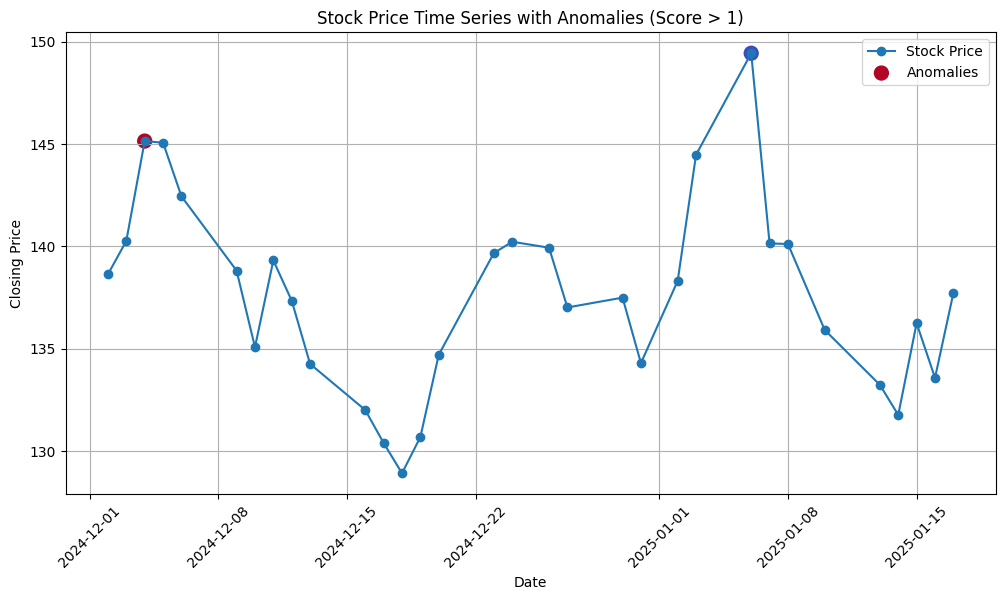

Anomaly Detection Results:
             close  anomaly_score
date                             
2024-12-02  138.63       0.000000
2024-12-03  140.26       0.000000
2024-12-04  145.14       2.470536
2024-12-05  145.06       0.548584
2024-12-06  142.44       0.025134
2024-12-09  138.81       0.000000
2024-12-10  135.07       0.000000
2024-12-11  139.31       0.000000
2024-12-12  137.34       0.000000
2024-12-13  134.25       0.000000
2024-12-16  132.00       0.000000
2024-12-17  130.39       0.000000
2024-12-18  128.91       0.000000
2024-12-19  130.68       0.000000
2024-12-20  134.70       0.000000
2024-12-23  139.67       0.271537
2024-12-24  140.22       0.315532
2024-12-26  139.93       0.273583
2024-12-27  137.01       0.000000
2024-12-30  137.49       0.013950
2024-12-31  134.29       0.000000
2025-01-02  138.31       0.121045
2025-01-03  144.47       0.817609
2025-01-06  149.43       1.299962
2025-01-07  140.14       0.203572
2025-01-08  140.11       0.195934
2025-01-10  135.91   

In [ ]:
import numpy as np
from news_signals import anomaly_detection

def detect_anomalies(timeseries, sigma_multiple=1.):
    anomaly_detector = anomaly_detection.SigmaAnomalyDetector(sigma_multiple=sigma_multiple)
    anomalies = []

    for i in range(1, len(timeseries)):
        history = timeseries.iloc[:i] 
        if len(history) < 2:
            anomalies.append(0)
            continue
        
        test_value = timeseries.iloc[i]
        test_series = pd.Series([test_value], index=[timeseries.index[i]])

        anomaly_score = anomaly_detector(history, test_series)
        score = anomaly_score.iloc[0] if isinstance(anomaly_score, pd.Series) else float(anomaly_score)
        anomalies.append(score)

    df_anomalies = timeseries.to_frame(name="close")
    df_anomalies["anomaly_score"] = [0] + anomalies
    return df_anomalies


sigma_multiple = 2.0
df_anomalies = detect_anomalies(timeseries, sigma_multiple=sigma_multiple)

anomaly_points = df_anomalies[df_anomalies["anomaly_score"] > 1]

plt.figure(figsize=(12, 6))
plt.plot(df_anomalies.index, df_anomalies["close"], marker="o", linestyle="-", label="Stock Price")

plt.scatter(
    anomaly_points.index, anomaly_points["close"],
    c=anomaly_points["anomaly_score"], cmap="coolwarm", s=100, label="Anomalies"
)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Price Time Series with Anomalies (Score > 1)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()
print("Anomaly Detection Results:")
print(df_anomalies)

